In [147]:
import os
import sys
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.stats
import tqdm

import util_figures
import util_stimuli

sys.path.append('bez2018model')
import bez2018model


In [2]:
fn_bez2018model_config = "stimuli/spkr_word_recognition/optimization/valid/tfrecords_IHC3000/config.json"
with open(fn_bez2018model_config, "r") as f:
    bez2018model_config = json.load(f)
kwargs_nervegram = bez2018model_config["kwargs_ExampleProcessor"]["kwargs_nervegram"]
kwargs_nervegram


{'IhcLowPass_cutoff': 3000,
 'IhcLowPass_order': 7,
 'bandwidth_scale_factor': 1.0,
 'buffer_end_dur': 0.0,
 'buffer_start_dur': 0.0,
 'cf_list': None,
 'cihc': 1.0,
 'cohc': 1.0,
 'implnt': 0,
 'max_cf': 8000.0,
 'max_spikes_per_train': 1000,
 'min_cf': 125,
 'nervegram_dtype': 'float16',
 'nervegram_dur': None,
 'nervegram_fs': 10000.0,
 'nervegram_spike_tensor_fs': 100000.0,
 'noiseType': 1,
 'num_cf': 50,
 'num_spike_trains': 1,
 'pin_dBSPL': None,
 'pin_dBSPL_flag': 0,
 'pin_fs': 100000.0,
 'random_seed': None,
 'return_meanrates': True,
 'return_spike_tensor_dense': False,
 'return_spike_tensor_sparse': False,
 'return_spike_times': False,
 'return_vihcs': False,
 'species': 2,
 'spont': [70.0, 4.0, 0.1],
 'squeeze_channel_dim': True,
 'squeeze_spont_dim': True,
 'synapseMode': 0,
 'tabs': 0.0006,
 'trel': 0.0006}

In [140]:
fn = "stimuli/spkr_word_recognition/evaluation/human_experiment_v00_foreground60dbspl/stim.hdf5"
index = -1
with h5py.File(fn, "r") as f:
    y = f["signal"][index]
    y_sr = f["sr"][index]

# t = np.arange(0, len(y)) / y_sr
# y = np.sin(2 * np.pi * 440.0 * t)
# y = util_stimuli.set_dBSPL(y, 60.0)

ipd.display(ipd.Audio(rate=y_sr, data=y))


In [141]:
out = bez2018model.nervegram(y, y_sr, **kwargs_nervegram)
for k in out.keys():
    v = np.array(out[k])
    print("|__ {} : {}".format(k, (v, v.dtype) if v.ndim == 0 else (v.shape, v.dtype)))


|__ signal : ((40000,), dtype('float32'))
|__ signal_fs : (array(20000), dtype('int64'))
|__ pin : ((200000,), dtype('float32'))
|__ pin_fs : (array(100000.), dtype('float64'))
|__ nervegram_fs : (array(10000.), dtype('float64'))
|__ nervegram_dur : (array(2.), dtype('float64'))
|__ nervegram_spike_tensor_fs : (array(100000.), dtype('float64'))
|__ cf_list : ((50,), dtype('float32'))
|__ bandwidth_scale_factor : ((50,), dtype('float32'))
|__ species : (array(2), dtype('int64'))
|__ spont : ((3,), dtype('float64'))
|__ buffer_start_dur : (array(0.), dtype('float64'))
|__ buffer_end_dur : (array(0.), dtype('float64'))
|__ pin_dBSPL_flag : (array(0), dtype('int64'))
|__ pin_dBSPL : (array(60.00342675), dtype('float64'))
|__ synapseMode : (array(0), dtype('int64'))
|__ max_spikes_per_train : (array(1000), dtype('int64'))
|__ num_spike_trains : (array(1), dtype('int64'))
|__ cohc : ((50,), dtype('float64'))
|__ cihc : ((50,), dtype('float64'))
|__ IhcLowPass_cutoff : (array(3000), dtype('in

In [144]:
refractory_period = 1e-3
anf_per_channel = [384, 160, 96]

dict_to_plot = {}
for index_spont, key in enumerate(["HSR", "MSR", "LSR"]):
    spont = out["spont"][index_spont]
    n = anf_per_channel[index_spont]
    rates = out["nervegram_meanrates"][:, :, index_spont]
    rates_sr = out["nervegram_fs"]
    refractory_samples = int(refractory_period * rates_sr)
    prob = rates / rates_sr
    # Binomial spike sampling (ignores refractory effects)
    spikes = np.random.rand(*([n] + list(prob.shape))) < prob[None, ...]
    spikes = spikes.astype(int)
    # Introduce refractoriness by iterating ove time samples and eliminating spikes during refractory period
    spikes_refractory = spikes.copy().reshape(-1, spikes.shape[-1])
    t_max = spikes.shape[-1]
    for t in tqdm.tqdm(range(0, t_max)):
        SPIKED_AT_T = spikes_refractory[:, t] > 0
        spikes_refractory[SPIKED_AT_T, t + 1 : min(t_max, t + refractory_samples)] = 0
    spikes_refractory = spikes_refractory.reshape(spikes.shape)
    spikes = spikes.sum(axis=0)
    spikes_refractory = spikes_refractory.sum(axis=0)
    dict_to_plot[key] = {
        "sr": rates_sr,
        "rates": rates,
        "spikes": spikes,
        "spikes_refractory": spikes_refractory,
    }


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 54624.64it/s]


HSR: r=0.991991, r2=0.984045, p=0.0
MSR: r=0.996073, r2=0.992161, p=0.0
LSR: r=0.995181, r2=0.990385, p=0.0


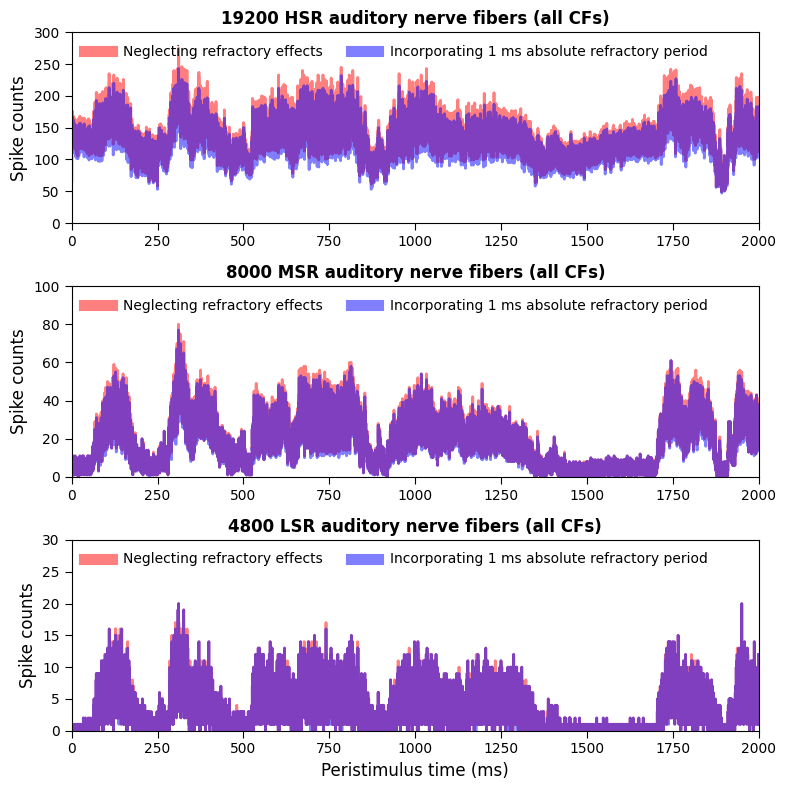

HSR: r=0.991991, r2=0.984045, p=0.0
MSR: r=0.996073, r2=0.992161, p=0.0
LSR: r=0.995181, r2=0.990385, p=0.0


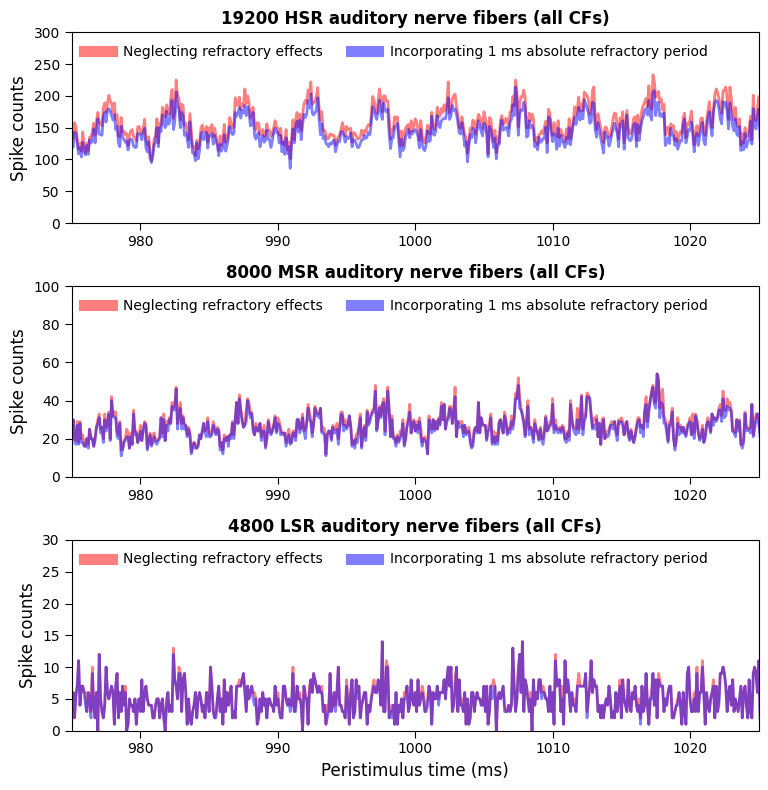

In [149]:
for xlimits in [[0, 2e3], [975, 1025]]:
    for index_freq in [
        None,
        # np.argmin(np.abs(out["cf_list"] - 440)),
    ]:
        if index_freq is not None:
            cf = out["cf_list"][index_freq]
            print(f"ANFs at CF: {cf}")
        fig, ax_arr = plt.subplots(
            figsize=(8, 8),
            nrows=len(dict_to_plot),
            ncols=1,
        )
        for itr_ax, key in enumerate(dict_to_plot.keys()):
            ax = ax_arr[itr_ax]
            spikes = dict_to_plot[key]["spikes"]
            spikes_refractory = dict_to_plot[key]["spikes_refractory"]
            t = np.arange(spikes.shape[-1]) / dict_to_plot[key]["sr"]
            kwargs_plot = {
                "lw": 2,
                "color": "r",
                "alpha": 0.5,
                "label": "Neglecting refractory effects",
            }
            kwargs_plot_refractory = {
                "lw": 2,
                "color": "b",
                "alpha": 0.5,
                "label": "Incorporating {:.0f} ms absolute refractory period".format(1e3 * refractory_period),
            }
            if index_freq is not None:
                str_title = "{} {} auditory nerve fibers with CF = {:.0f} Hz".format(anf_per_channel[itr_ax], key, cf)
                ax.plot(1e3 * t, spikes[index_freq], **kwargs_plot)
                ax.plot(1e3 * t, spikes_refractory[index_freq], **kwargs_plot_refractory)
                r, p = scipy.stats.pearsonr(spikes[index_freq], spikes_refractory[index_freq])
            else:
                str_title = "{} {} auditory nerve fibers (all CFs)".format(anf_per_channel[itr_ax] * spikes.shape[0], key)
                ax.plot(1e3 * t, spikes.sum(axis=0), **kwargs_plot)
                ax.plot(1e3 * t, spikes_refractory.sum(axis=0), **kwargs_plot_refractory)
                r, p = scipy.stats.pearsonr(spikes.sum(axis=0), spikes_refractory.sum(axis=0))
            print("{}: r={:.6f}, r2={:.6f}, p={}".format(key, r, r ** 2, p))
            leg = ax.legend(
                ncols=2,
                frameon=False,
                loc="upper left",
            )
            for line in leg.get_lines():
                line.set_linewidth(8.0)
            ax = util_figures.format_axes(
                ax,
                xlimits=xlimits,
                ylimits=[0, [300, 100, 30][itr_ax]] if index_freq is None else None,
                str_xlabel="Peristimulus time (ms)" if itr_ax == 2 else None,
                str_ylabel="Spike counts",
                str_title=str_title,
                fontsize_ticks=10,
                fontweight_title="bold",
            )
        plt.tight_layout()
        plt.show()


In [119]:
index_freq = np.argmin(np.abs(out["cf_list"] - 250))
index_spont = 0
cf = out["cf_list"][index_freq]
rate = out["nervegram_meanrates"][index_freq, :, index_spont]
rate_sr = out["nervegram_fs"]
cf, rate.shape


(258.9663, (20000,))

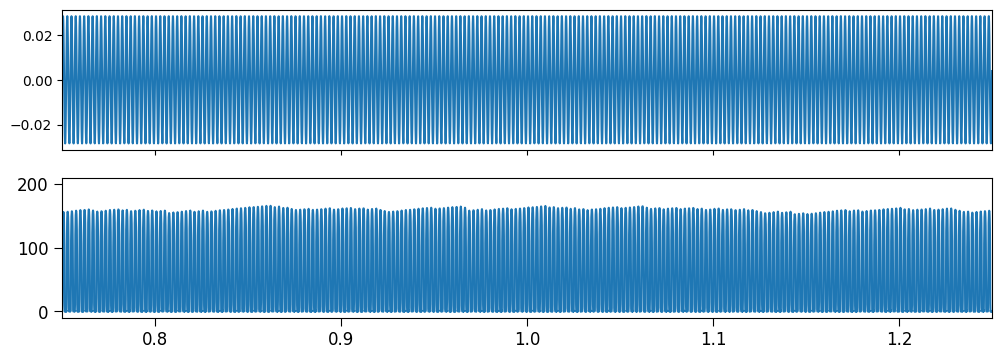

In [120]:
fig, ax_arr = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(12, 4),
    sharex=True,
)

y_t = np.arange(len(y)) / y_sr
ax_arr[0].plot(y_t, y)

rate_t = np.arange(len(rate)) / rate_sr
ax_arr[1].plot(rate_t, rate)

util_figures.format_axes(
    ax_arr[1],
    xlimits=[0.75, 1.25],
)
plt.show()
